# Setup

**Imports**

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from loadmydata.load_human_locomotion import (
    load_human_locomotion_dataset,
    get_code_list,
)

**Utility functions**

In [5]:
def fig_ax(figsize=(15, 5)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.autoscale(enable=True, axis='x', tight=True)
    return fig, ax

# Spectral feature

## Question 6

In [6]:
def sample_autocovariances(N, n_trials = 100):
    autocovs = np.zeros((n_trials, N))
    X = np.random.randn(n_trials, N) * 1.
    for tau in range(N):
        autocovs[:,tau] =  1/N * np.sum((X[:,:N-tau] * X[:,tau:N]), axis = 1)
    return autocovs

In [7]:
def periodogram(N, n_trials = 100):
    J_fk2 = np.zeros((n_trials, N))
    X = np.random.randn(n_trials, N) * 1.
    autocovs = sample_autocovariances(N, n_trials = n_trials)
    for k in range(N):
        J_fk2[:,k] =  2*sum([autocovs[:,tau] * np.cos(2*np.pi*k*tau/N) for tau in range(1,N)])
    constant_term = 1/N * np.sum(X**2, axis = 1)
    J_fk2 = J_fk2 + constant_term[:,None]
    return J_fk2

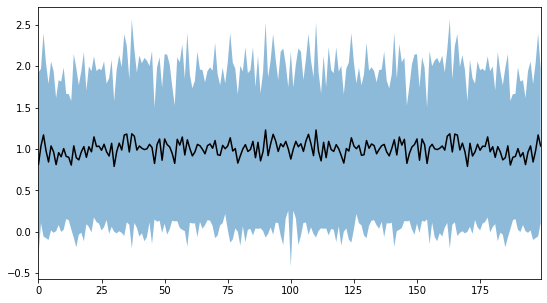

In [18]:
# This is an example of plot (random data). You can change it if you want.

N = 200

## Change the following lines
periodograms = periodogram(N)  # shape (n_trials, n_freqs)
freqs = np.arange(0, N)
##


fig, ax = fig_ax(figsize=(9, 5))

avg = periodograms.mean(axis=0)
std = periodograms.std(axis=0)
ax.plot(freqs, avg, 'k-')
ax.fill_between(freqs, avg-std, avg+std, alpha=0.5)


## Question 9

# Dynamic time warping (DTW)

## Data

This data set consists of signals collected with inertial measurement units (accelerometer+gyroscope), from 230 subjects undergoing a fixed protocol:
- standing still,
- walking 10 m,
- turning around,
- walking back,
- stopping.

In this assignment, we only consider the vertical acceleration of the left foot and all signals are truncated to 20 seconds (as a result, they all have same length). Signals are sampled at 100 Hz.

The measured population is composed of healthy subjects as well as patients with neurological or orthopedic disorders.

The start and end time stamps of thousands of footsteps are available.

The data are part of a larger data set described in [1].

[1] Truong, C., Barrois-Müller, R., Moreau, T., Provost, C., Vienne-Jumeau, A., Moreau, A., Vidal, P.-P., Vayatis, N., Buffat, S., Yelnik, A., Ricard, D., & Oudre, L. (2019). A data set for the study of human locomotion with inertial measurements units. Image Processing On Line (IPOL), 9.

**The task** is to classify footsteps in healthy/non-healthy.

The following cell defines the training set `(X_train, y_train)` and testing set `(X_test, y_test)`.

In [8]:
subset_indexes_train = [95, 619, 441, 149, 951, 803, 214, 34, 37, 630]
subset_indexes_test = [683, 259, 59, 387, 634]

code_list = get_code_list()

X_train = list()  # list of footstep signals
y_train = list()  # list of pathologies (the "labels")

for code in np.take(code_list, subset_indexes_train):
    single_trial = load_human_locomotion_dataset(code)
    signal = single_trial.signal.LAZ.to_numpy()  # keeping only one dimension (from the left sensor)
    steps = single_trial.left_steps
    pathology = single_trial.metadata["PathologyGroup"]
    label = 0 if pathology=="Healthy" else 1  # 0: healthy, 1: non-healthy
    for (start, end) in steps:
        X_train.append(signal[start:end])
        y_train.append(label)

        
X_test = list()  # list of footstep signals
y_test = list()  # list of pathologies (the "labels")

for code in np.take(code_list, subset_indexes_test):
    single_trial = load_human_locomotion_dataset(code)
    signal = single_trial.signal.LAZ.to_numpy()  # keeping only one dimension (from the left sensor)
    steps = single_trial.left_steps
    pathology = single_trial.metadata["PathologyGroup"]
    label = 0 if pathology=="Healthy" else 1  # 0: healthy, 1: non-healthy
    for (start, end) in steps:
        X_test.append(signal[start:end])
        y_test.append(label)

100%|██████████| 202M/202M [07:10<00:00, 469kiB/s]  


## Question 10

In [9]:
# Imports

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import GridSearchCV

from scipy.spatial.distance import pdist, squareform

from dtw import dtw

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [10]:
def get_dtw_distance(signal_1: np.ndarray, signal_2: np.ndarray) -> float:
    return dtw(signal_1, signal_2, keep_internals=True).distance

In [11]:
# Precompute the dtw distances between the signals

train_matrix = np.zeros((len(X_train), len(X_train)))
test_matrix = np.zeros((len(X_test), len(X_train)))

for i in range(len(X_train)):
    for j in range(i, len(X_train)):
        train_matrix[i, j] = get_dtw_distance(X_train[i], X_train[j])
        train_matrix[j, i] = train_matrix[i, j]

for i in range(len(X_test)):
    for j in range(len(X_train)):
        test_matrix[i, j] = get_dtw_distance(X_test[i], X_train[j])

In [12]:
clf = KNeighborsClassifier(metric = 'precomputed')
param_grid = {'n_neighbors': np.arange(1,30)}
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='f1')
grid_search.fit(train_matrix, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(metric='precomputed'),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])},
             scoring='f1')

In [13]:
best_score = grid_search.best_score_
best_k = grid_search.best_params_['n_neighbors']
best_clf = grid_search.best_estimator_

print(f"Best F-score: {best_score} \nBest n_neighbors: {best_k}")

Best F-score: 0.76999333999334 
Best n_neighbors: 5


In [28]:
# Fit a classifier with best_k on the whole training dataset
clf = KNeighborsClassifier(n_neighbors=best_k, metric = 'precomputed')
clf.fit(train_matrix, y_train)

KNeighborsClassifier(metric='precomputed')

In [29]:
# Check F-score on test dataset
y_pred = clf.predict(test_matrix)
f1 = f1_score(y_test, y_pred)
f1

0.4545454545454545

## Question 11